In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy
from sklearn.metrics import r2_score
import pmdarima as pm

In [2]:
fileName = 'C:/Users/mcarp/OneDrive/Documents/Monthly NYC Accident Data - Master Sheet.csv'
months = pd.read_csv(fileName)
dfmonthly = pd.DataFrame(months)

In [3]:
largeFile='C:/Users/mcarp/Downloads/Motor_Vehicle_Collisions_-_Crashes.csv'
large_file = pd.read_csv(largeFile)
dfCrash = pd.DataFrame(large_file)

In [4]:
lastFile='C:/Users/mcarp/OneDrive/Documents/Collision Monthly Borough.csv'
_file = pd.read_csv(lastFile)
dfBoroughs = pd.DataFrame(_file)

In [5]:
dfBoroughs['Injuries']=dfBoroughs['MotoristsInjured']+dfBoroughs['PassengersInjured']+dfBoroughs['PedestriansInjured']+dfBoroughs['CyclistsInjured']
dfBoroughs['Injuries/Population'] = dfBoroughs['Injuries']/dfBoroughs['PopEstimate(2019)']
dfBoroughs['Fatalities']=dfBoroughs['MotoristsKilled']+dfBoroughs['PassengersKilled']+dfBoroughs['PedestriansKilled']+dfBoroughs['CyclistsKilled']
dfBoroughs['Fatalities/Population'] = dfBoroughs['Fatalities']/dfBoroughs['PopEstimate(2019)']
dfBoroughs['Cyclist/Pedestrian Injuries']=dfBoroughs['CyclistsInjured']+dfBoroughs['PedestriansInjured']
dfBoroughs['Cyclist/Pedestrian Fatalities']=dfBoroughs['CyclistsKilled']+dfBoroughs['PedestriansKilled']
dfBoroughs['Date'] = dfBoroughs['Month'].astype(str)+'-'+dfBoroughs['Year'].astype(str)
dfBoroughs['Inj_or_fatal_coll_Population']=100000*dfBoroughs['Injury_or_fatal_collisions']/dfBoroughs['PopEstimate(2019)']

In [6]:
dfStat = dfBoroughs[dfBoroughs['Borough']=='STATEN ISLAND']
dfMan = dfBoroughs[dfBoroughs['Borough']=='MANHATTAN']
dfBk = dfBoroughs[dfBoroughs['Borough']=='BROOKLYN']
dfBronx = dfBoroughs[dfBoroughs['Borough']=='BRONX']
dfQueens = dfBoroughs[dfBoroughs['Borough']=='QUEENS']

print(dfStat.shape,dfMan.shape,dfBk.shape,dfBronx.shape,dfQueens.shape)

(110, 22) (110, 22) (110, 22) (110, 22) (110, 22)


In [7]:
dfStat=dfStat.reset_index()
del dfStat['index']
dfMan=dfMan.reset_index()
del dfMan['index']
dfBk=dfBk.reset_index()
del dfBk['index']
dfBronx=dfBronx.reset_index()
del dfBronx['index']
dfQueens=dfQueens.reset_index()
del dfQueens['index']
dfQueens.head(2)

,Year,Month,Borough,PopEstimate(2019),Num_Motor_Vehicle_Collisions,Injury_or_fatal_collisions,MotoristsInjured,MotoristsKilled,PassengersInjured,PassengersKilled,...,PedestriansInjured,PedestriansKilled,Injuries,Injuries/Population,Fatalities,Fatalities/Population,Cyclist/Pedestrian Injuries,Cyclist/Pedestrian Fatalities,Date,Inj_or_fatal_coll_Population
0,2012,1,QUEENS,2272222,4380,855,447,2,456,2,...,238,1,1170,0.000515,5,0.000002,267,1,1-2012,37.628366
1,2012,2,QUEENS,2272222,3946,785,420,1,426,0,...,240,4,1111,0.000489,5,0.000002,265,4,2-2012,34.547681


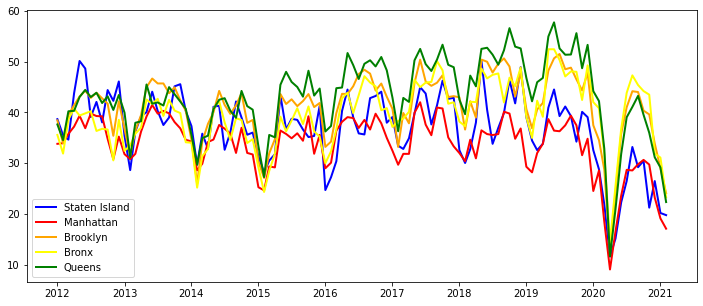

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(pd.to_datetime(dfStat.Date),'Inj_or_fatal_coll_Population', data=dfStat, marker='', color='blue', linewidth=2, label="Staten Island")
plt.plot(pd.to_datetime(dfMan.Date),'Inj_or_fatal_coll_Population', data=dfMan, marker='', color='red', linewidth=2, label="Manhattan")
plt.plot(pd.to_datetime(dfBk.Date),'Inj_or_fatal_coll_Population', data=dfBk, marker='', color='orange', linewidth=2, label="Brooklyn")
plt.plot(pd.to_datetime(dfBronx.Date),'Inj_or_fatal_coll_Population', data=dfBronx, marker='', color='yellow', linewidth=2, label="Bronx")
plt.plot(pd.to_datetime(dfQueens.Date),'Inj_or_fatal_coll_Population', data=dfQueens, marker='', color='green', linewidth=2, label="Queens")
plt.legend()
plt.show()

In [9]:
dfs=[dfMan[:96],dfBronx[:96],dfBk[:96],dfQueens[:96],dfStat[:96]]
for df in dfs:
    f, PSD = scipy.signal.periodogram(df['Inj_or_fatal_coll_Population'])
    PSD = PSD[f>0.01]
    f = f[f>0.01]
    print('Strongest period of {0} = {1}'.format(df['Borough'][1],1/f[np.argmax(PSD)]))

Strongest period of MANHATTAN = 12.0
Strongest period of BRONX = 96.0
Strongest period of BROOKLYN = 12.0
Strongest period of QUEENS = 96.0
Strongest period of STATEN ISLAND = 6.0


In [10]:
for df in dfs:
    print(df['Borough'][1],df['Inj_or_fatal_coll_Population'][84:96].mean())

MANHATTAN 34.608251376655254
BRONX 45.47408570587134
BROOKLYN 45.538834869914986
QUEENS 50.635399390733575
STATEN ISLAND 38.20630916902416


In [12]:
df_monthly=dfMan[['Date','Injury_or_fatal_collisions']].copy()
df_monthly['Injury_or_fatal_collisions']=dfMan['Injury_or_fatal_collisions']+dfBk['Injury_or_fatal_collisions']+dfBronx['Injury_or_fatal_collisions']+dfQueens['Injury_or_fatal_collisions']+dfStat['Injury_or_fatal_collisions']
df_monthly['PopEstimate(2019)']=dfMan['PopEstimate(2019)']+dfBk['PopEstimate(2019)']+dfBronx['PopEstimate(2019)']+dfQueens['PopEstimate(2019)']+dfStat['PopEstimate(2019)']
df_monthly['Inj_or_fatal_coll_Population']=100000*df_monthly['Injury_or_fatal_collisions']/df_monthly['PopEstimate(2019)']
df_monthly.head(2)

,Date,Injury_or_fatal_collisions,PopEstimate(2019),Inj_or_fatal_coll_Population
0,1-2012,3075,8346693,36.840938
1,2-2012,2823,8346693,33.821778


In [13]:
print(df_monthly['Inj_or_fatal_coll_Population'][84:96].mean())

44.35145931594756


_________________________________________________________________________

## Bronx Model

In [14]:
f, PSD = scipy.signal.periodogram(dfBronx['Inj_or_fatal_coll_Population'][:96])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 96.0


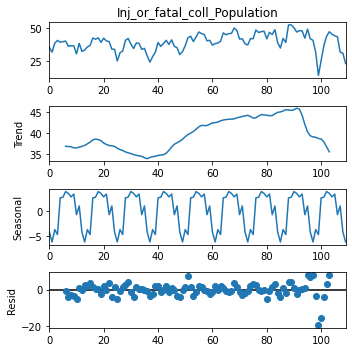

In [15]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfBronx['Inj_or_fatal_coll_Population'],model='additive',freq=12)
res.plot()
plt.show()

In [16]:
result = adfuller(dfBronx['Inj_or_fatal_coll_Population'])
print('p-value: %f' % result[1])
result = adfuller(dfBronx['Inj_or_fatal_coll_Population'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.832994
p-value: 0.001118


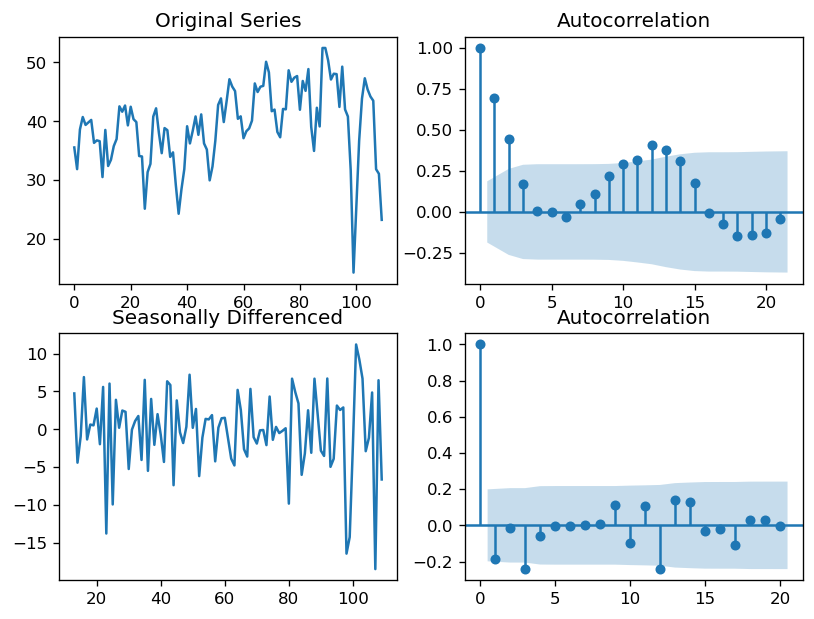

In [17]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfBronx['Inj_or_fatal_coll_Population']); axes[0, 0].set_title('Original Series')
plot_acf(dfBronx['Inj_or_fatal_coll_Population'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfBronx['Inj_or_fatal_coll_Population'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfBronx['Inj_or_fatal_coll_Population'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [18]:
model = pm.auto_arima(dfBronx['Inj_or_fatal_coll_Population'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=587.208, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=601.506, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=592.604, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=585.899, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=599.178, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=587.898, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=587.898, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=592.332, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=585.211, Time=0.20 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=587.207, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=592.550, Time=0.17 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=586.120, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AI

In [19]:
trainBronx=dfBronx[['Date','Inj_or_fatal_coll_Population']][:84]
validBronx=dfBronx[['Date','Inj_or_fatal_coll_Population']][84:96]
testBronx=dfBronx[['Date','Inj_or_fatal_coll_Population']][96:]
modelBronx = SARIMAX(trainBronx['Inj_or_fatal_coll_Population'],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBronx = modelBronx.fit()
resultsBronx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:       Inj_or_fatal_coll_Population   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -182.045
Date:                            Wed, 28 Apr 2021   AIC                            372.090
Time:                                    19:20:16   BIC                            381.141
Sample:                                         0   HQIC                           375.690
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2149      0.242      0.887      0.375      -0.260       0.690
ma.L1         -0.7110      0.178     -3.986      0.000      -1.061      -0.361
ma.S.L12      -0.9984     40.012     -0.025      0.980     -79.420      77.423
sigma2         7.0900    283.303      0.025      0.980    -548.173     562.353
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.77
Prob(Q):                              0.89   Prob(JB):                         0.15
Heteroskedasticity (H):               0.58   Skew:                            -0.35
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

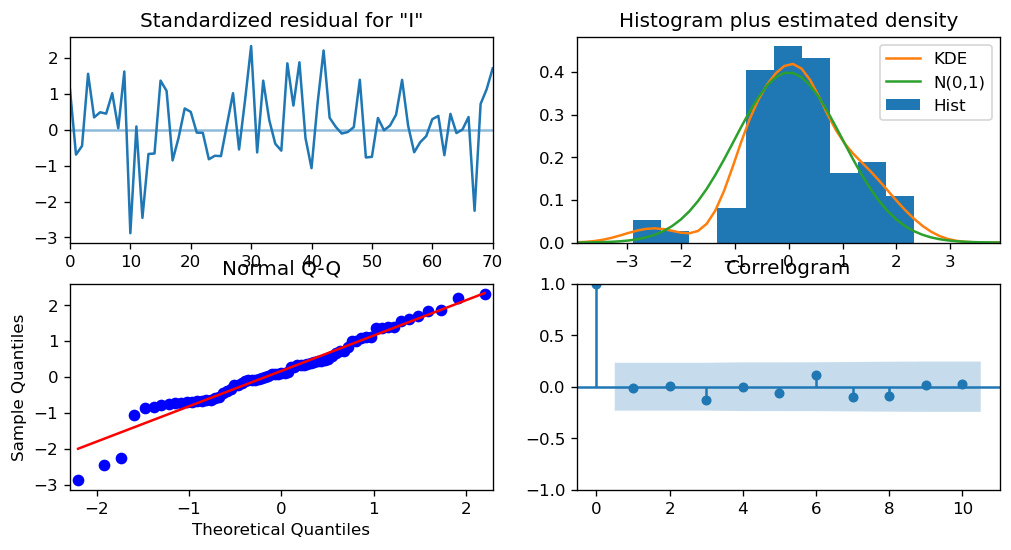

In [127]:
resultsBronx.plot_diagnostics()
plt.show()

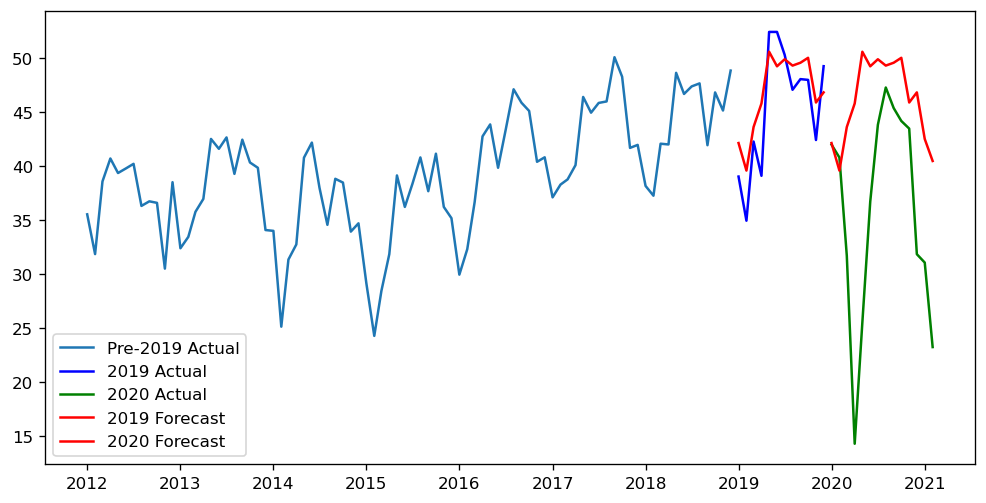

In [20]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainBronx.Date), trainBronx['Inj_or_fatal_coll_Population'],label='Pre-2019 Actual')
plt.plot(pd.to_datetime(validBronx.Date), validBronx['Inj_or_fatal_coll_Population'],color='blue',label='2019 Actual')
plt.plot(pd.to_datetime(testBronx.Date), testBronx['Inj_or_fatal_coll_Population'],color='green',label='2020 Actual')
plt.plot(pd.to_datetime(validBronx.Date), resultsBronx.forecast(steps=len(validBronx), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testBronx.Date), resultsBronx.forecast(steps=len(testBronx), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [21]:
r2_score(validBronx['Inj_or_fatal_coll_Population'], resultsBronx.forecast(steps=len(validBronx), alpha=0.05))

0.6662220561393515

In [22]:
r2_score(testBronx['Inj_or_fatal_coll_Population'], resultsBronx.forecast(steps=len(testBronx), alpha=0.05))

-1.11813831611438

In [23]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
mean_absolute_percentage_error(validBronx['Inj_or_fatal_coll_Population'],resultsBronx.forecast(steps=len(validBronx)))

6.432877345651667

In [25]:
mean_absolute_percentage_error(testBronx['Inj_or_fatal_coll_Population'],resultsBronx.forecast(steps=len(testBronx)))

42.68610281581979

## Bronx Model MAPE 2019: 6.43%, 2020: 42.7%

In [28]:
x=np.arange(144)

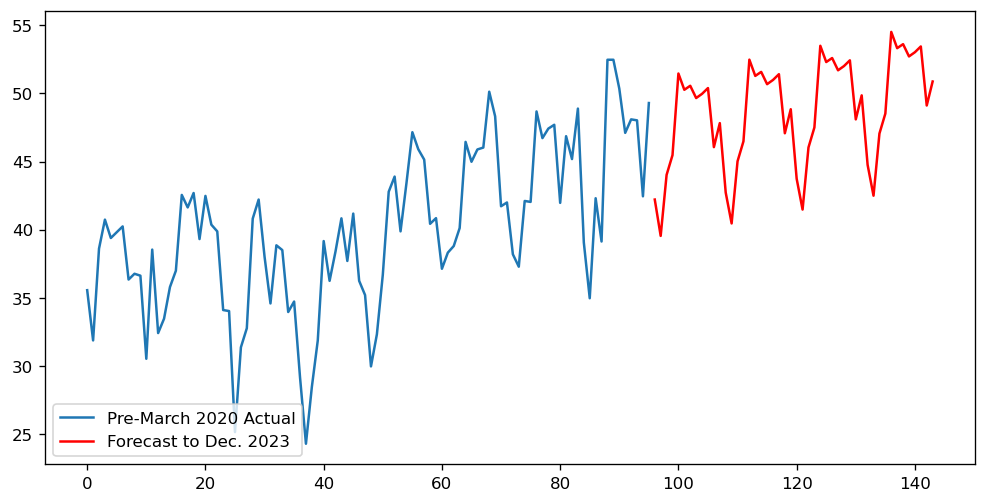

In [29]:
modelBronx2 = SARIMAX(dfBronx['Inj_or_fatal_coll_Population'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBronx2 = modelBronx2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfBronx.index[:96], dfBronx['Inj_or_fatal_coll_Population'][:96],label='Pre-March 2020 Actual')
plt.plot(x[96:], resultsBronx2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [30]:
res=resultsBronx2.forecast(24)
res[12:].mean()

48.24513050828225

In [31]:
res=resultsBronx2.forecast(36)
res[24:].mean()

49.26223484501852

In [32]:
res=resultsBronx2.forecast(48)
res[36:].mean()

50.27933918202936

In [33]:
res=resultsBronx2.forecast(60)
res[48:].mean()

51.296443519040196

## Projected Avgs./Month/Year: 48.2, 49.3, 50.3, 51.3

___________________________________________________________________________________________________________________________

## Staten Island Model

Period of 6 months (as opposed to 12 in other boroughs)

In [37]:
f, PSD = scipy.signal.periodogram(dfStat['Inj_or_fatal_coll_Population'][:96])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 6.0


In [38]:
result = adfuller(dfStat['Inj_or_fatal_coll_Population'])
print('p-value: %f' % result[1])
result = adfuller(dfStat['Inj_or_fatal_coll_Population'].diff().diff(6).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.990411
p-value: 0.000000


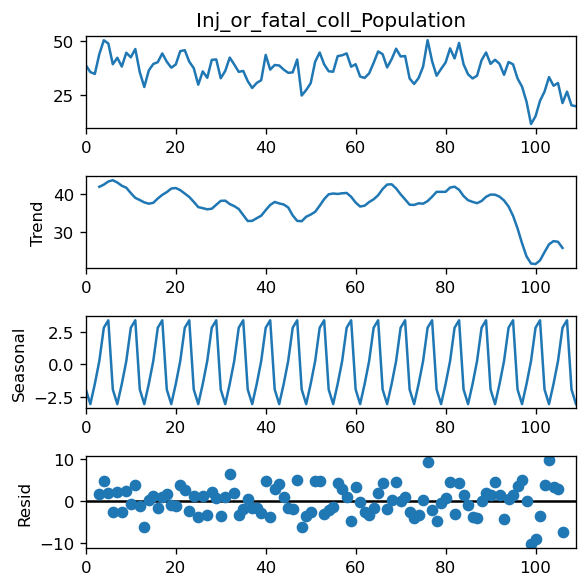

In [39]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfStat['Inj_or_fatal_coll_Population'],model='additive',freq=6)
res.plot()
plt.show()

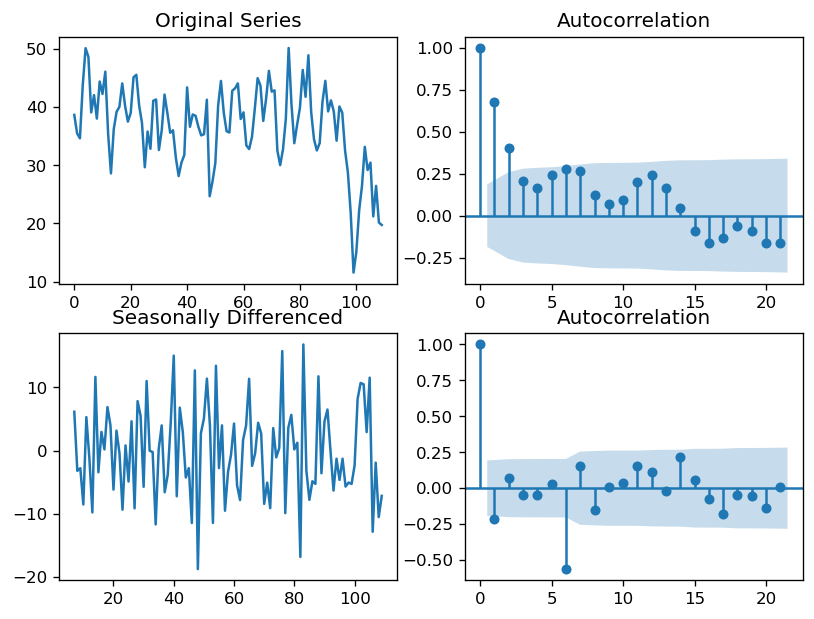

In [40]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfStat['Inj_or_fatal_coll_Population']); axes[0, 0].set_title('Original Series')
plot_acf(dfStat['Inj_or_fatal_coll_Population'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfStat['Inj_or_fatal_coll_Population'].diff().diff(6)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfStat['Inj_or_fatal_coll_Population'].diff().diff(6).dropna(), ax=axes[1, 1])
plt.show()

In [41]:
model = pm.auto_arima(dfStat['Inj_or_fatal_coll_Population'], d=1, D=1,
                      m=6, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=12, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=646.269, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=706.392, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=659.539, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=644.039, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=703.945, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=644.362, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[6]             : AIC=644.659, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[6]             : AIC=654.759, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,2)(0,1,1)[6]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,1,1)[6]             : AIC=644.521, Time=0.22 sec
 ARIMA(1,1,2)(0,1,1)[6]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[6] intercept   : AIC=644.039, Time=0.24 sec

B

In [42]:
trainSt=dfStat[['Date','Inj_or_fatal_coll_Population']][:84]
validSt=dfStat[['Date','Inj_or_fatal_coll_Population']][84:96]
testSt=dfStat[['Date','Inj_or_fatal_coll_Population']][96:]
modelSt = SARIMAX(trainSt['Inj_or_fatal_coll_Population'],order=(0,1,1),seasonal_order=(0,1,1,6))
resultsSt = modelSt.fit()
resultsSt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:      Inj_or_fatal_coll_Population   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 6)   Log Likelihood                -228.729
Date:                           Wed, 28 Apr 2021   AIC                            463.459
Time:                                   19:24:16   BIC                            470.490
Sample:                                        0   HQIC                           466.271
                                            - 84                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5206      0.132     -3.950      0.000      -0.779      -0.262
ma.S.L6       -0.9997     78.211     -0.013      0.990    -154.291     152.292
sigma2        18.0657   1412.815      0.013      0.990   -2751.001    2787.132
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 1.60
Prob(Q):                              0.65   Prob(JB):                         0.45
Heteroskedasticity (H):               1.24   Skew:                             0.12
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

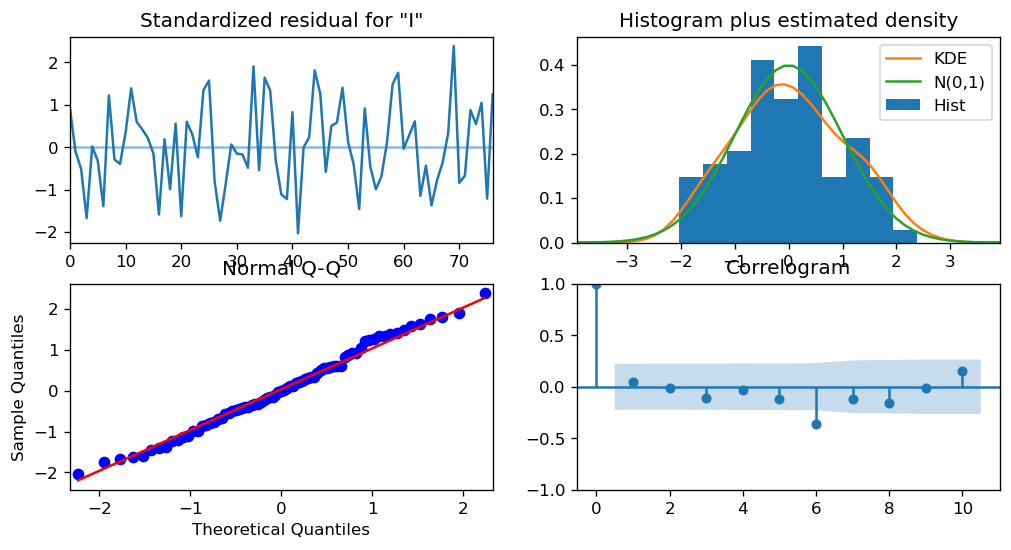

In [128]:
resultsSt.plot_diagnostics()
plt.show()

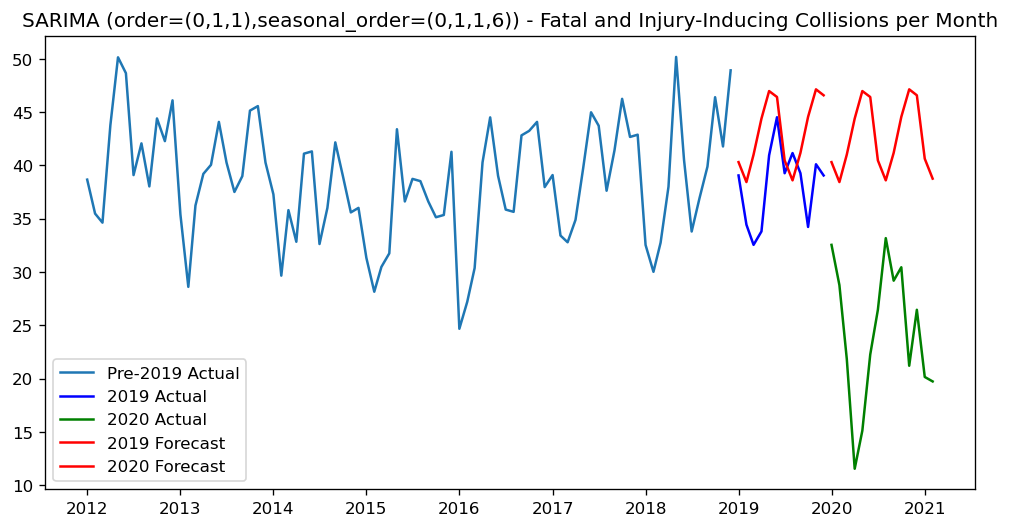

In [43]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainSt.Date), trainSt['Inj_or_fatal_coll_Population'],label='Pre-2019 Actual')
plt.plot(pd.to_datetime(validSt.Date), validSt['Inj_or_fatal_coll_Population'],color='blue',label='2019 Actual')
plt.plot(pd.to_datetime(testSt.Date), testSt['Inj_or_fatal_coll_Population'],color='green',label='2020 Actual')
plt.plot(pd.to_datetime(validSt.Date), resultsSt.forecast(steps=len(validSt), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testSt.Date), resultsSt.forecast(steps=len(testSt), alpha=0.05), label='2020 Forecast', color='red')
plt.title('SARIMA (order=(0,1,1),seasonal_order=(0,1,1,6)) - Fatal and Injury-Inducing Collisions per Month')
plt.legend(loc='lower left')

In [44]:
r2_score(validSt['Inj_or_fatal_coll_Population'], resultsSt.forecast(steps=len(validSt), alpha=0.05))

-2.2148071794456285

In [45]:
r2_score(testSt['Inj_or_fatal_coll_Population'], resultsSt.forecast(steps=len(testSt), alpha=0.05))

-9.37117190547463

In [46]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
mean_absolute_percentage_error(validSt['Inj_or_fatal_coll_Population'],resultsSt.forecast(steps=len(validSt)))

14.34936258659907

In [48]:
mean_absolute_percentage_error(testSt['Inj_or_fatal_coll_Population'],resultsSt.forecast(steps=len(testSt)))

92.98009636404412

## Staten Island MAPE 2019: 14.3%, 2020: 92.9%

In [31]:
x = np.arange(144)

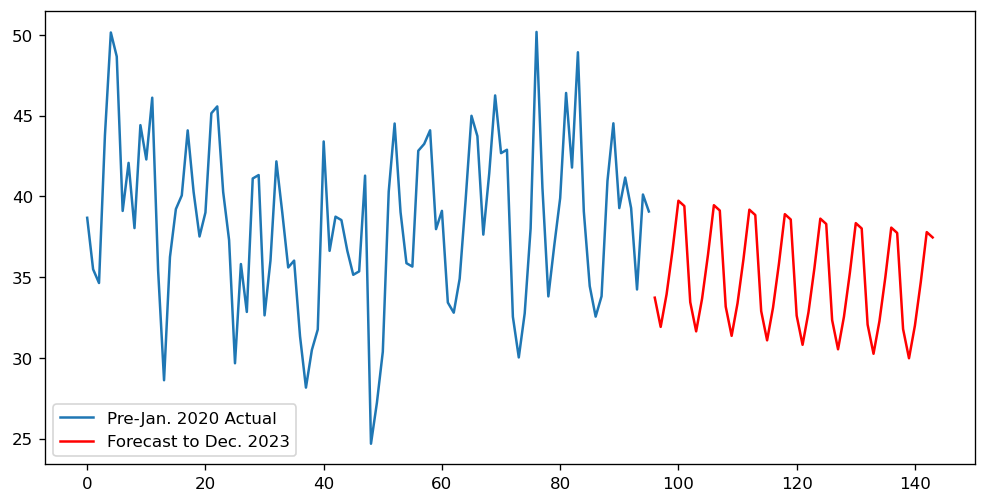

In [49]:
modelSt2 = SARIMAX(dfStat['Inj_or_fatal_coll_Population'][:96],order=(0,1,1),seasonal_order=(0,1,1,6))
resultsSt2 = modelSt2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfStat.index[:96], dfStat['Inj_or_fatal_coll_Population'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsSt2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [50]:
res=resultsSt2.forecast(24)
res[12:].mean()

35.2012618964745

In [51]:
res=resultsSt2.forecast(36)
res[24:].mean()

34.646023457989735

In [52]:
res=resultsSt2.forecast(48)
res[36:].mean()

34.09078501950496

In [53]:
res=resultsSt2.forecast(60)
res[48:].mean()

33.53554658102018

## Projected Avgs./Month/Year: 35.2, 34.6, 34.1, 33.5

_________________________________________________________________________________________________________________

## Queens Model

In [54]:
f, PSD = scipy.signal.periodogram(dfQueens['Inj_or_fatal_coll_Population'][:96])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 96.0


In [55]:
result = adfuller(dfQueens['Inj_or_fatal_coll_Population'])
print('p-value: %f' % result[1])
result = adfuller(dfQueens['Inj_or_fatal_coll_Population'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.747897
p-value: 0.000000


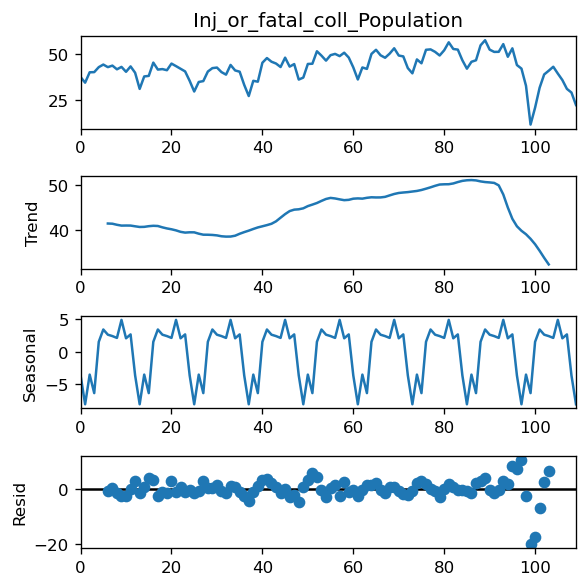

In [57]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfQueens['Inj_or_fatal_coll_Population'],model='additive',freq=12)
res.plot()
plt.show()

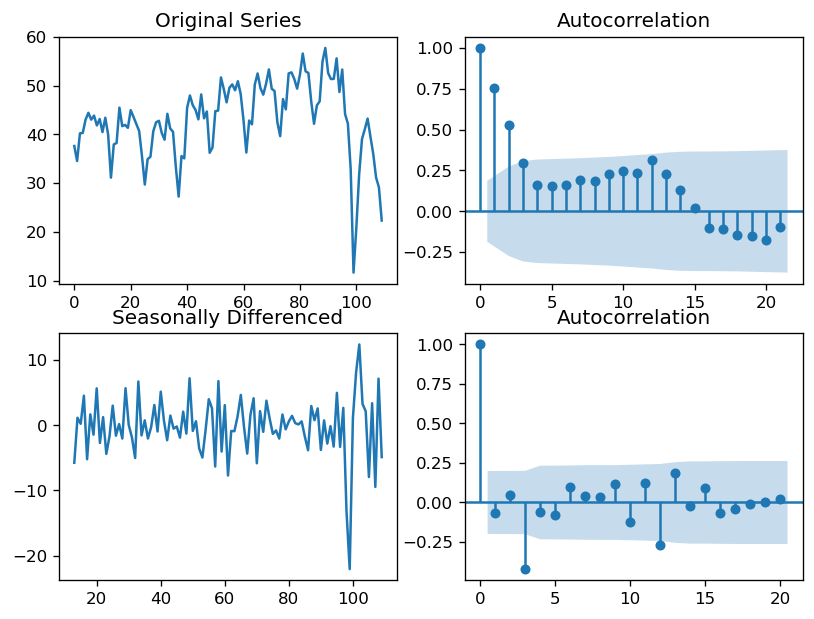

In [58]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfQueens['Inj_or_fatal_coll_Population']); axes[0, 0].set_title('Original Series')
plot_acf(dfQueens['Inj_or_fatal_coll_Population'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfQueens['Inj_or_fatal_coll_Population'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfQueens['Inj_or_fatal_coll_Population'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [59]:
model = pm.auto_arima(dfQueens['Inj_or_fatal_coll_Population'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=556.356, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=572.239, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=560.191, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=556.651, Time=0.26 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=555.457, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=556.233, Time=0.31 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=558.442, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=558.218, Time=0.98 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=556.707, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=558.650, Time=0.35 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=555.457, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 3.025 seconds


In [60]:
trainQn=dfQueens[['Date','Inj_or_fatal_coll_Population']][:84]
validQn=dfQueens[['Date','Inj_or_fatal_coll_Population']][84:96]
testQn=dfQueens[['Date','Inj_or_fatal_coll_Population']][96:]
modelQn = SARIMAX(trainQn['Inj_or_fatal_coll_Population'],order=(0,1,0),seasonal_order=(0,1,1,12))
resultsQn = modelQn.fit()
resultsQn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:         Inj_or_fatal_coll_Population   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -166.426
Date:                              Wed, 28 Apr 2021   AIC                            336.851
Time:                                      19:26:49   BIC                            341.376
Sample:                                           0   HQIC                           338.651
                                               - 84                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9953     15.865     -0.063      0.950     -32.090      30.099
sigma2         4.6096     72.785      0.063      0.950    -138.047     147.266
===================================================================================
Ljung-Box (L1) (Q):                   6.68   Jarque-Bera (JB):                 2.95
Prob(Q):                              0.01   Prob(JB):                         0.23
Heteroskedasticity (H):               0.41   Skew:                             0.50
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

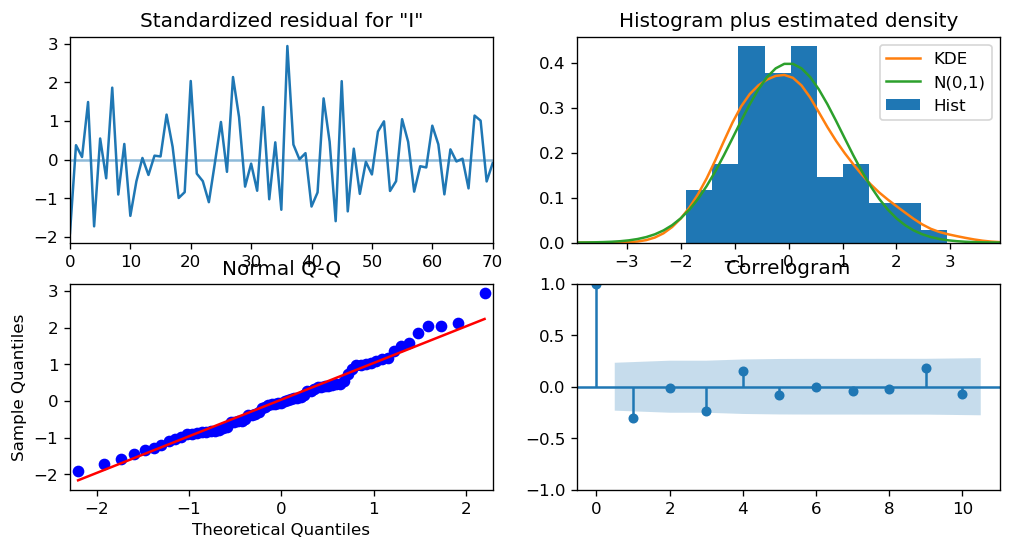

In [129]:
resultsQn.plot_diagnostics()
plt.show()

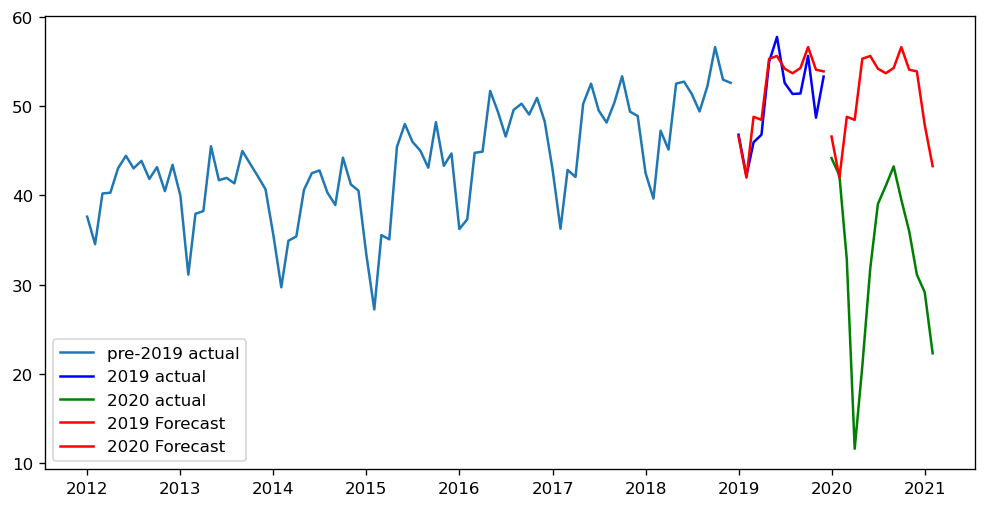

In [61]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainQn.Date), trainQn['Inj_or_fatal_coll_Population'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validQn.Date), validQn['Inj_or_fatal_coll_Population'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testQn.Date), testQn['Inj_or_fatal_coll_Population'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validQn.Date), resultsQn.forecast(steps=len(validQn), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testQn.Date), resultsQn.forecast(steps=len(testQn), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [62]:
print('2019 R2 Score:',r2_score(validQn['Inj_or_fatal_coll_Population'], resultsQn.forecast(steps=len(validQn), alpha=0.05)))
print('2020 R2 Score:',r2_score(testQn['Inj_or_fatal_coll_Population'], resultsQn.forecast(steps=len(testQn), alpha=0.05)))

2019 R2 Score: 0.7342041963029593
2020 R2 Score: -3.8197562590344605


In [63]:
mean_absolute_percentage_error(validQn['Inj_or_fatal_coll_Population'],resultsQn.forecast(steps=len(validQn)))

3.4985530965797027

In [64]:
mean_absolute_percentage_error(testQn['Inj_or_fatal_coll_Population'],resultsQn.forecast(steps=len(testQn)))

73.66166259857846

## Queens Model MAPE 2019: 3.50%, 2020: 73.7%

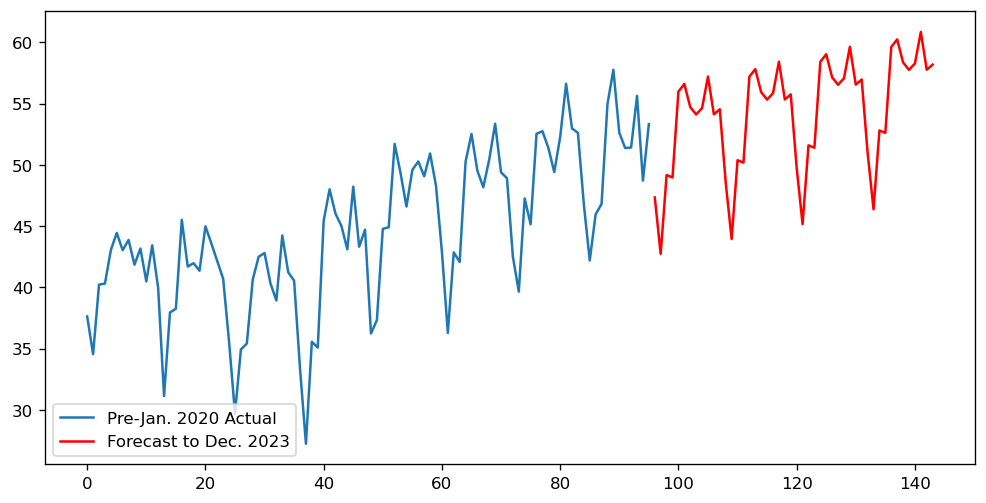

In [66]:
modelQn2 = SARIMAX(dfQueens['Inj_or_fatal_coll_Population'][:96],order=(0,1,0),seasonal_order=(0,1,1,12))
resultsQn2 = modelQn2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfMan.index[:96], dfQueens['Inj_or_fatal_coll_Population'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsQn2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [67]:
res=resultsQn2.forecast(24)
res[12:].mean()

53.7300648995045

In [68]:
res=resultsQn2.forecast(36)
res[24:].mean()

54.94450537029405

In [69]:
res=resultsQn2.forecast(48)
res[36:].mean()

56.1589458410836

In [70]:
res=resultsQn2.forecast(60)
res[48:].mean()

57.373386311873155

## Predicted Avgs./Month/Year: 53.7, 54.9, 56.2, 57.4

 _______________________________________________________________________________________________________________________

## Manhattan Model

In [71]:
f, PSD = scipy.signal.periodogram(dfMan['Inj_or_fatal_coll_Population'][:96])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.0


In [72]:
result = adfuller(dfMan['Inj_or_fatal_coll_Population'])
print('p-value: %f' % result[1])
result = adfuller(dfMan['Inj_or_fatal_coll_Population'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.993381
p-value: 0.000875


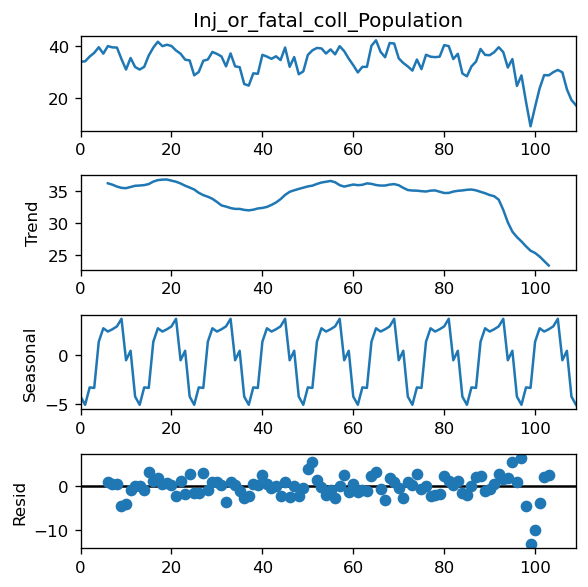

In [73]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfMan['Inj_or_fatal_coll_Population'],model='additive',freq=12)
res.plot()
plt.show()

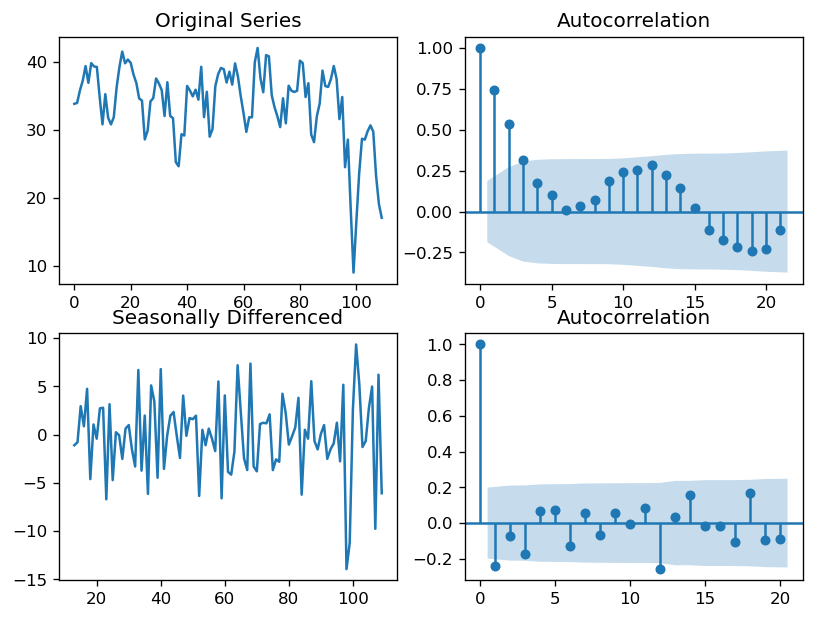

In [74]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfMan['Inj_or_fatal_coll_Population']); axes[0, 0].set_title('Original Series')
plot_acf(dfMan['Inj_or_fatal_coll_Population'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfMan['Inj_or_fatal_coll_Population'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfMan['Inj_or_fatal_coll_Population'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [75]:
model = pm.auto_arima(dfMan['Inj_or_fatal_coll_Population'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=532.876, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=550.820, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=535.876, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=526.733, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=543.788, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=528.664, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=528.650, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=532.555, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=530.999, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=522.600, Time=0.57 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=540.128, Time=0.19 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=524.582, Time=0.65 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=524.578, Time=0.77 sec
 ARIMA(1,1,1)(1,1,0)[12]             

In [76]:
trainMan=dfMan[['Date','Inj_or_fatal_coll_Population']][:84]
validMan=dfMan[['Date','Inj_or_fatal_coll_Population']][84:96]
testMan=dfMan[['Date','Inj_or_fatal_coll_Population']][96:]
modelMan = SARIMAX(trainMan['Inj_or_fatal_coll_Population'],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsMan = modelMan.fit()
resultsMan.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:       Inj_or_fatal_coll_Population   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -169.476
Date:                            Wed, 28 Apr 2021   AIC                            346.953
Time:                                    19:29:42   BIC                            356.003
Sample:                                         0   HQIC                           350.552
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0949      0.259      0.367      0.714      -0.412       0.602
ma.L1         -0.6711      0.195     -3.449      0.001      -1.053      -0.290
ma.S.L12      -0.7178      0.192     -3.738      0.000      -1.094      -0.341
sigma2         6.1020      1.199      5.091      0.000       3.753       8.451
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.95   Prob(JB):                         0.50
Heteroskedasticity (H):               0.91   Skew:                             0.21
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

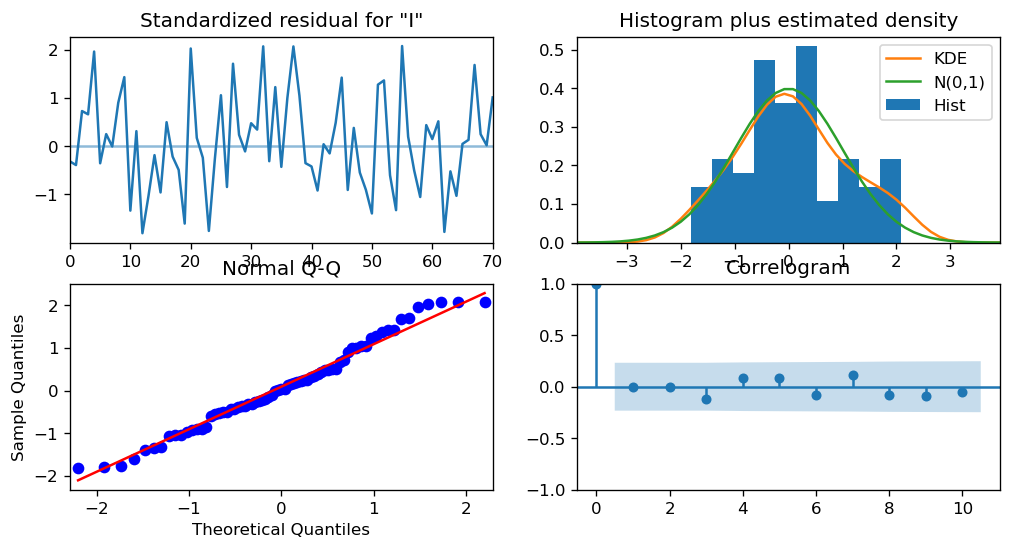

In [130]:
resultsMan.plot_diagnostics()
plt.show()

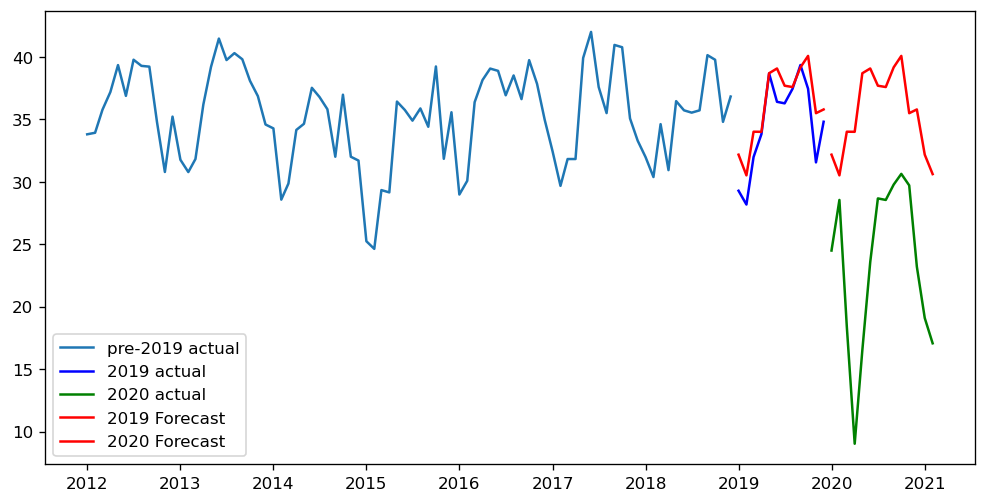

In [77]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainMan.Date), trainMan['Inj_or_fatal_coll_Population'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validMan.Date), validMan['Inj_or_fatal_coll_Population'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testMan.Date), testMan['Inj_or_fatal_coll_Population'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validMan.Date), resultsMan.forecast(steps=len(validMan), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testMan.Date), resultsMan.forecast(steps=len(testMan), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [78]:
r2_score(validMan['Inj_or_fatal_coll_Population'], resultsMan.forecast(steps=len(validMan), alpha=0.05))

0.6578942459378923

In [79]:
r2_score(testMan['Inj_or_fatal_coll_Population'], resultsMan.forecast(steps=len(testMan), alpha=0.05))

-3.614915625495456

In [80]:
mean_absolute_percentage_error(validMan['Inj_or_fatal_coll_Population'],resultsMan.forecast(steps=len(validMan)))

4.956996740219568

In [81]:
mean_absolute_percentage_error(testMan['Inj_or_fatal_coll_Population'],resultsMan.forecast(steps=len(testMan)))

67.63449730736167

## Manhattan Model MAPE 2019: 4.96%, 2020: 67.6%

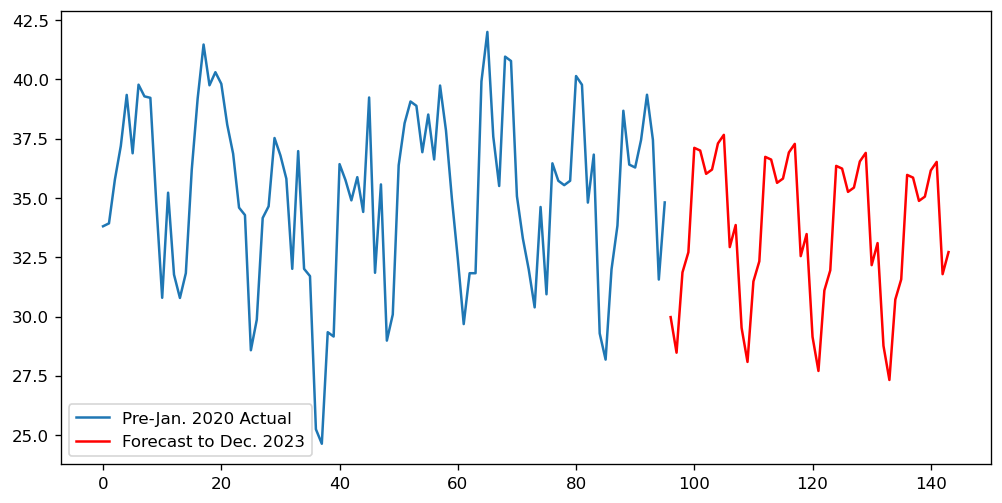

In [82]:
modelMan2 = SARIMAX(dfMan['Inj_or_fatal_coll_Population'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsMan2 = modelMan2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfMan.index[:96], dfMan['Inj_or_fatal_coll_Population'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsMan2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [83]:
res=resultsMan2.forecast(24)
res[12:].mean()

33.87187350508986

In [84]:
res=resultsMan2.forecast(36)
res[24:].mean()

33.49121310502721

In [85]:
res=resultsMan2.forecast(48)
res[36:].mean()

33.11055270496467

In [86]:
res=resultsMan2.forecast(60)
res[48:].mean()

32.72989230490213

## Projected Avgs./Month/Year: 33.9, 33.5, 33.1, 32.7

 _______________________________________________________________________________________________________________________

## Brooklyn Model

In [87]:
f, PSD = scipy.signal.periodogram(dfBk['Inj_or_fatal_coll_Population'])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.222222222222221


In [88]:
result = adfuller(dfBk['Inj_or_fatal_coll_Population'])
print('p-value: %f' % result[1])
result = adfuller(dfBk['Inj_or_fatal_coll_Population'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.909402
p-value: 0.002788


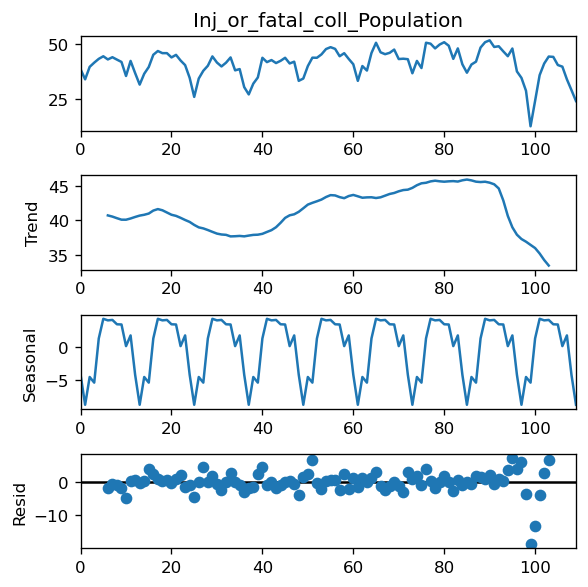

In [89]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfBk['Inj_or_fatal_coll_Population'],model='additive',freq=12)
res.plot()
plt.show()

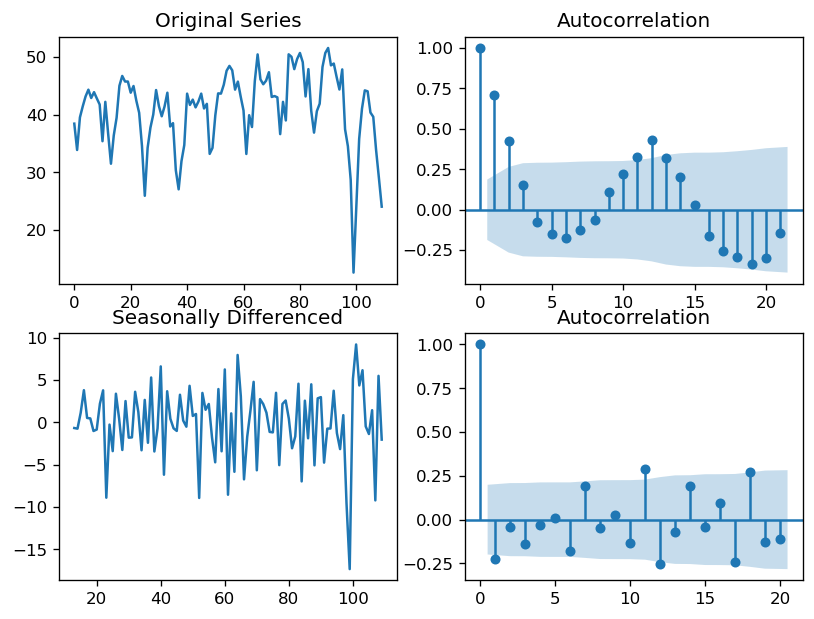

In [90]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfBk['Inj_or_fatal_coll_Population']); axes[0, 0].set_title('Original Series')
plot_acf(dfBk['Inj_or_fatal_coll_Population'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfBk['Inj_or_fatal_coll_Population'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfBk['Inj_or_fatal_coll_Population'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [91]:
model = pm.auto_arima(dfBk['Inj_or_fatal_coll_Population'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=546.982, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=562.755, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=553.191, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=545.244, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=558.263, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=547.212, Time=0.19 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=547.167, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=552.245, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=545.022, Time=0.17 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=546.913, Time=0.34 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=555.295, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=545.627, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AI

In [92]:
trainBk=dfBk[['Date','Inj_or_fatal_coll_Population']][:84]
validBk=dfBk[['Date','Inj_or_fatal_coll_Population']][84:96]
testBk=dfBk[['Date','Inj_or_fatal_coll_Population']][96:]

In [93]:
modelBk = SARIMAX(trainBk['Inj_or_fatal_coll_Population'],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBk = modelBk.fit()
resultsBk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:       Inj_or_fatal_coll_Population   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -170.116
Date:                            Wed, 28 Apr 2021   AIC                            348.232
Time:                                    19:32:47   BIC                            357.282
Sample:                                         0   HQIC                           351.831
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0192      0.196      0.098      0.922      -0.364       0.403
ma.L1         -0.6561      0.152     -4.303      0.000      -0.955      -0.357
ma.S.L12      -0.9975     22.169     -0.045      0.964     -44.448      42.453
sigma2         5.0645    111.727      0.045      0.964    -213.917     224.046
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.80   Prob(JB):                         0.67
Heteroskedasticity (H):               1.23   Skew:                            -0.23
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

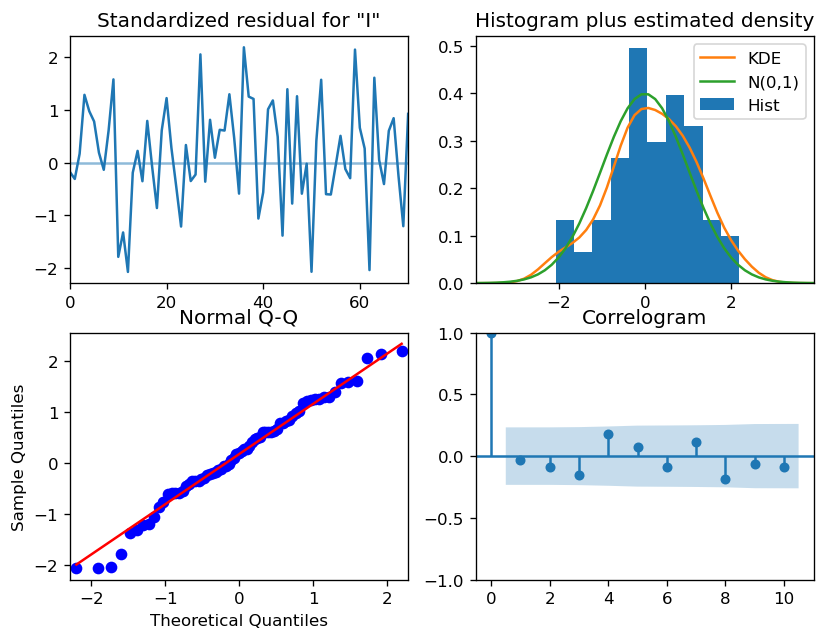

In [94]:
resultsBk.plot_diagnostics()
plt.show()

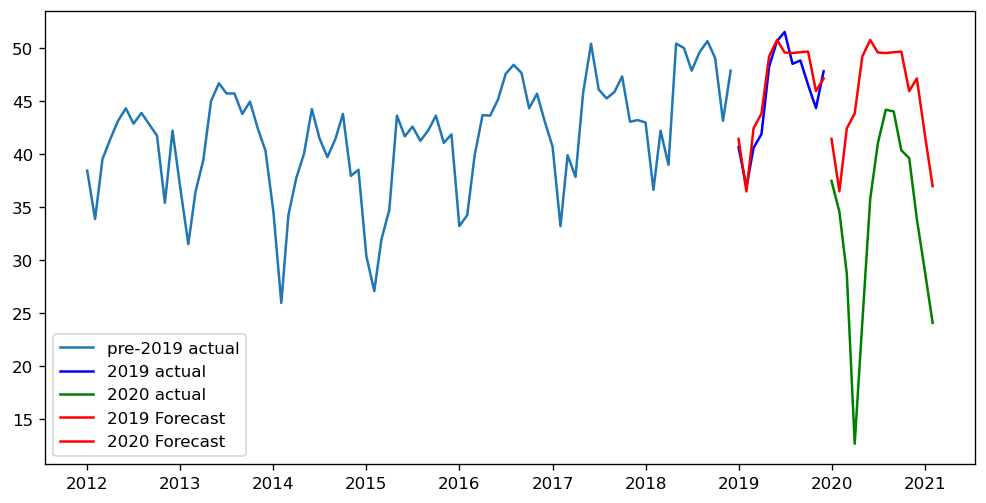

In [95]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainBk.Date), trainBk['Inj_or_fatal_coll_Population'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validBk.Date), validBk['Inj_or_fatal_coll_Population'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testBk.Date), testBk['Inj_or_fatal_coll_Population'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validBk.Date), resultsBk.forecast(steps=len(validBk), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testBk.Date), resultsBk.forecast(steps=len(testBk), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [96]:
r2_score(validBk['Inj_or_fatal_coll_Population'], resultsBk.forecast(steps=len(validBk), alpha=0.05))

0.8835586451997735

In [97]:
r2_score(testBk['Inj_or_fatal_coll_Population'], resultsBk.forecast(steps=len(testBk), alpha=0.05))

-1.6880313966137273

In [98]:
mean_absolute_percentage_error(validBk['Inj_or_fatal_coll_Population'],resultsBk.forecast(steps=len(validBk)))

2.8004544822007738

In [99]:
mean_absolute_percentage_error(testBk['Inj_or_fatal_coll_Population'],resultsBk.forecast(steps=len(testBk)))

48.4182071433561

## Brooklyn Model MAPE 2019: 2.80%, 2020: 48.4%

In [68]:
x = np.arange(144)

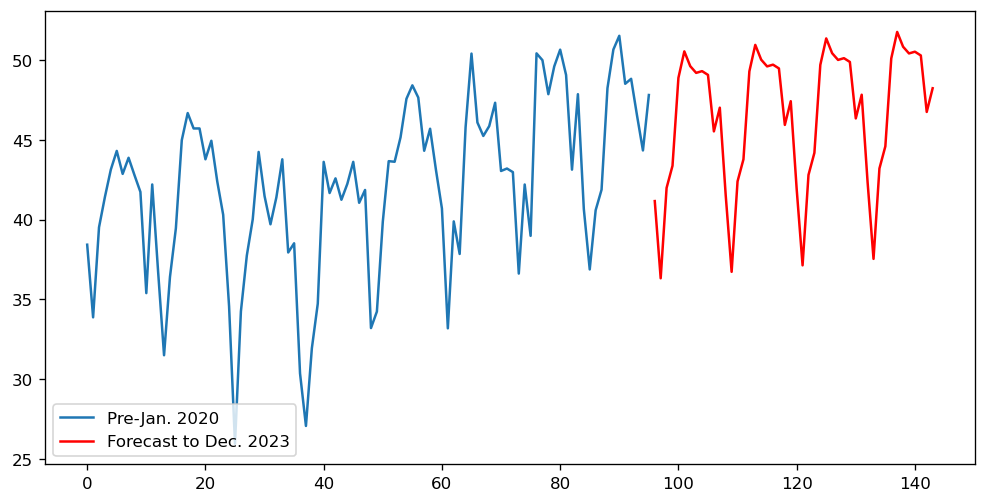

In [100]:
modelBk2 = SARIMAX(dfBk['Inj_or_fatal_coll_Population'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBk2 = modelBk2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfBk.index[:96], dfBk['Inj_or_fatal_coll_Population'][:96],label='Pre-Jan. 2020')
plt.plot(x[96:], resultsBk2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [101]:
res=resultsBk2.forecast(24)
res[12:].mean()

46.40612788144396

In [102]:
res=resultsBk2.forecast(36)
res[24:].mean()

46.812377820048646

In [103]:
res=resultsBk2.forecast(48)
res[36:].mean()

47.21862775865332

In [104]:
res=resultsBk2.forecast(60)
res[48:].mean()

47.62487769725799

## Projected Avgs./Month/Year: 46.4, 46.8, 47.2, 47.6

 _______________________________________________________________________________________________________________________

## Citywide Model

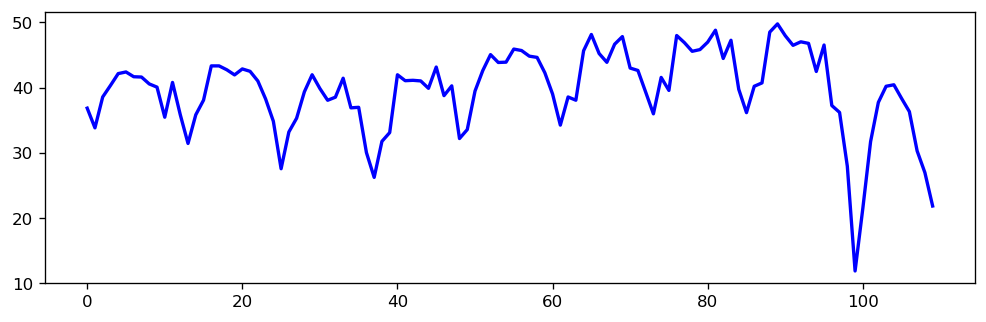

In [105]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(df_monthly.index,'Inj_or_fatal_coll_Population', data=df_monthly, marker='', color='blue', linewidth=2)
plt.show()

In [106]:
f, PSD = scipy.signal.periodogram(df_monthly['Inj_or_fatal_coll_Population'])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.222222222222221


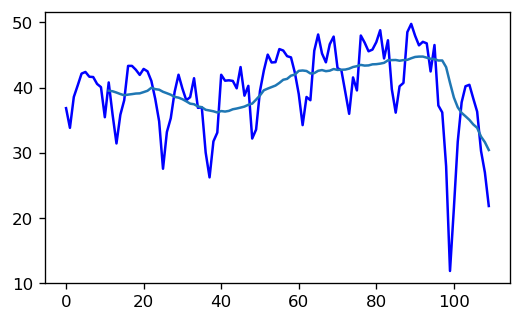

In [107]:
df_monthly['Inj_or_fatal_coll_Population'].plot(color='blue', figsize=(5, 3))
plt.plot(df_monthly['Inj_or_fatal_coll_Population'].rolling(window = 12).mean())

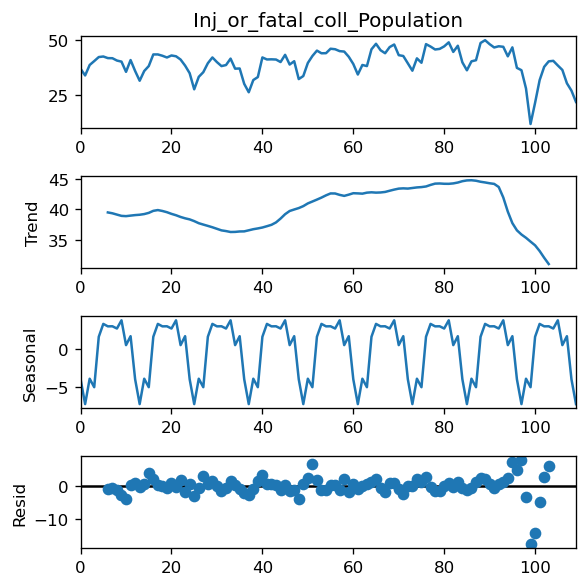

In [108]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(df_monthly['Inj_or_fatal_coll_Population'],model='additive',freq=12)
res.plot()
plt.show()

In [109]:
series = df_monthly['Inj_or_fatal_coll_Population'].diff().diff(12)
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.947551
p-value: 0.000000


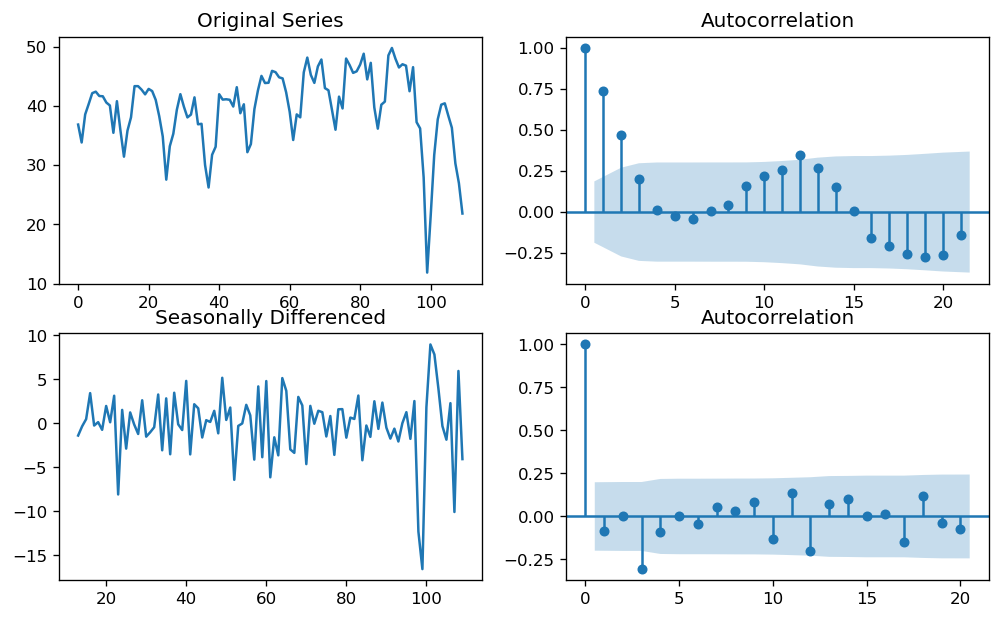

In [110]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(df_monthly['Inj_or_fatal_coll_Population']); axes[0, 0].set_title('Original Series')
plot_acf(df_monthly['Inj_or_fatal_coll_Population'].dropna(), ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df_monthly['Inj_or_fatal_coll_Population'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(df_monthly['Inj_or_fatal_coll_Population'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [111]:
import pmdarima as pm
model = pm.auto_arima(df_monthly['Inj_or_fatal_coll_Population'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=524.370, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=535.182, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=530.970, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=524.453, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=522.558, Time=0.09 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=524.004, Time=0.25 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=529.171, Time=0.11 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=524.464, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=526.445, Time=0.34 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=522.558, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 3.920 seconds


In [112]:
train=df_monthly[['Date','Inj_or_fatal_coll_Population']][:84]
valid=df_monthly[['Date','Inj_or_fatal_coll_Population']][84:96]
test=df_monthly[['Date','Inj_or_fatal_coll_Population']][96:]

In [114]:
model = SARIMAX(train['Inj_or_fatal_coll_Population'],order=(0,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:         Inj_or_fatal_coll_Population   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -158.932
Date:                              Wed, 28 Apr 2021   AIC                            321.864
Time:                                      20:35:19   BIC                            326.389
Sample:                                           0   HQIC                           323.663
                                               - 84                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9916      6.243     -0.159      0.874     -13.227      11.244
sigma2         3.7459     23.114      0.162      0.871     -41.558      49.049
===================================================================================
Ljung-Box (L1) (Q):                  10.36   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.00   Prob(JB):                         0.71
Heteroskedasticity (H):               0.97   Skew:                            -0.02
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

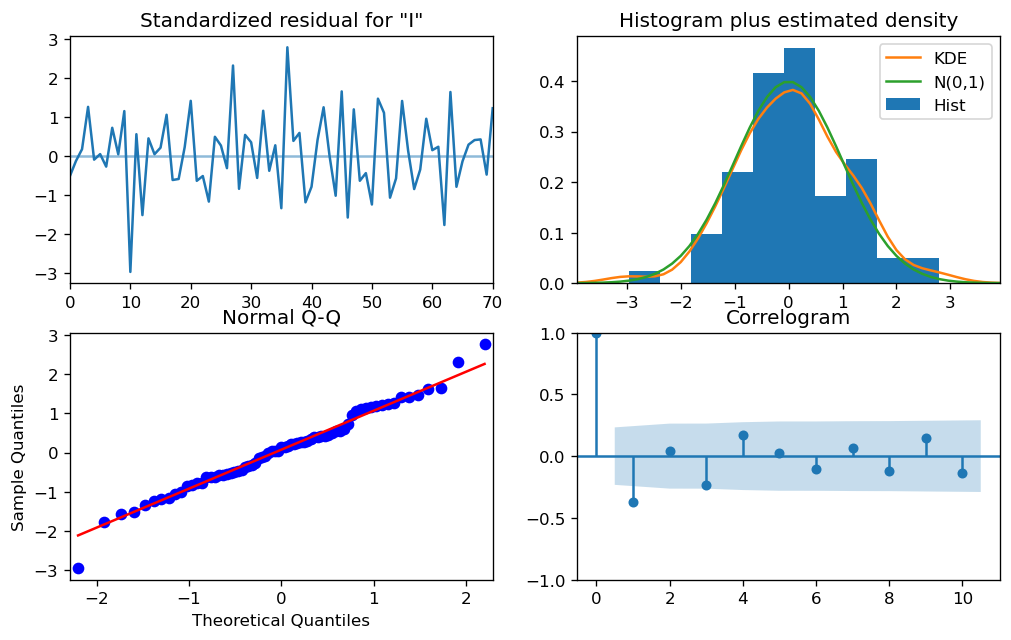

In [115]:
results.plot_diagnostics()
plt.show()

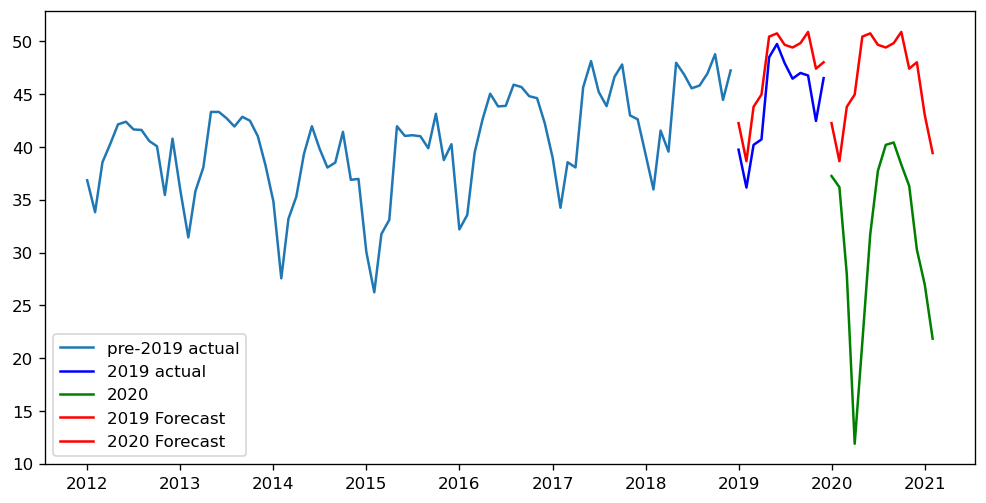

In [117]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(train.Date), train['Inj_or_fatal_coll_Population'],label='pre-2019 actual')
plt.plot(pd.to_datetime(valid.Date), valid['Inj_or_fatal_coll_Population'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(test.Date), test['Inj_or_fatal_coll_Population'],color='green',label='2020')
plt.plot(pd.to_datetime(valid.Date), results.forecast(steps=len(valid), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(test.Date), results.forecast(steps=len(test), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [118]:
r2_score(valid['Inj_or_fatal_coll_Population'], results.forecast(steps=len(valid), alpha=0.05))

0.45097249187651267

In [119]:
r2_score(test['Inj_or_fatal_coll_Population'], results.forecast(steps=len(test), alpha=0.05))

-3.35796249700683

In [120]:
mean_absolute_percentage_error(valid['Inj_or_fatal_coll_Population'],results.forecast(steps=len(valid)))

6.532304964015738

In [121]:
mean_absolute_percentage_error(test['Inj_or_fatal_coll_Population'],results.forecast(steps=len(test)))

63.56813209527591

## Citywide Model MAPE 2019: 6.53%, 2020: 63.6%

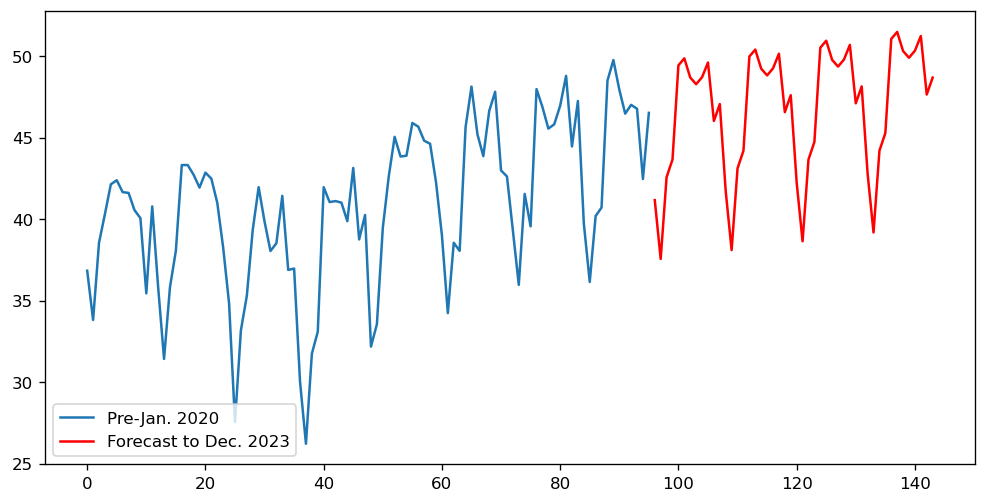

In [122]:
model2 = SARIMAX(df_monthly['Inj_or_fatal_coll_Population'][:96],order=(0,1,0),seasonal_order=(0,1,1,12))
results2 = model2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(df_monthly.index[:96], df_monthly['Inj_or_fatal_coll_Population'][:96],label='Pre-Jan. 2020')
plt.plot(x[96:], results2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [123]:
res=results2.forecast(24)
res[12:].mean()

46.590212026944755

In [124]:
res=results2.forecast(36)
res[24:].mean()

47.13096178444882

In [125]:
res=results2.forecast(48)
res[36:].mean()

47.671711541952874

In [126]:
res=results2.forecast(60)
res[48:].mean()

48.212461299456926

## Projected Avgs./Month/Year: 46.6, 47.1, 47.7, 48.2